In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from typing import List 
import pandas as pd 

%matplotlib inline
from IPython.display import HTML, display
from PIL import Image
from pathlib import Path
from torchvision import transforms
from torchvision.datasets import Flowers102
import torch.nn.functional as F
from torchsummary import summary
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns 

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

### Przygotowanie danych

#### Transformacje danych
[Wizualizacje transformacji](https://pytorch.org/vision/0.11/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)

In [2]:
DATASET_PATH = Path('../data/study')

In [3]:
class Transpose:

    def __init__(self, axes):
        self.axes=axes 

    def __call__(self, sample):
        return sample.permute(*self.axes)
        
    

type_transforms = transforms.Compose([
    transforms.PILToTensor(),
    # Transpose(axes=(1, 2, 0)),
    transforms.Resize(size=(256, 256)),
    transforms.ConvertImageDtype(torch.float)
])

In [4]:
transforms_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
])

transforms_2 = transforms.Compose([
    transforms.RandomAutocontrast(),
    transforms.RandomPerspective(distortion_scale=0.6, p=1.0)
])

In [5]:
orig_img = type_transforms(Image.open(DATASET_PATH / 'flowers-102/jpg/image_00001.jpg'))

In [6]:
orig_img.shape

torch.Size([3, 256, 256])

Zdjęcia mają już wyskalowane wartości, więc nie trzeba do nich stosować dodatkowych transformacji skalujących

In [7]:
orig_img

tensor([[[0.4902, 0.4667, 0.4275,  ..., 0.0706, 0.0902, 0.1059],
         [0.5059, 0.4784, 0.4392,  ..., 0.0588, 0.0745, 0.0863],
         [0.5333, 0.4980, 0.4510,  ..., 0.0471, 0.0627, 0.0706],
         ...,
         [0.5412, 0.5176, 0.4824,  ..., 0.2706, 0.2824, 0.2824],
         [0.5686, 0.5294, 0.4941,  ..., 0.2667, 0.2784, 0.2784],
         [0.5804, 0.5373, 0.5020,  ..., 0.2667, 0.2784, 0.2745]],

        [[0.4667, 0.4431, 0.4039,  ..., 0.0784, 0.0980, 0.1137],
         [0.4863, 0.4588, 0.4157,  ..., 0.0667, 0.0824, 0.0941],
         [0.5137, 0.4824, 0.4353,  ..., 0.0549, 0.0706, 0.0784],
         ...,
         [0.5804, 0.5569, 0.5255,  ..., 0.1961, 0.2078, 0.2078],
         [0.6000, 0.5647, 0.5412,  ..., 0.1922, 0.2039, 0.2039],
         [0.6078, 0.5765, 0.5490,  ..., 0.1922, 0.2039, 0.2000]],

        [[0.3725, 0.3490, 0.3020,  ..., 0.0275, 0.0471, 0.0627],
         [0.3961, 0.3608, 0.3059,  ..., 0.0157, 0.0314, 0.0431],
         [0.4235, 0.3804, 0.3137,  ..., 0.0039, 0.0196, 0.

In [8]:
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img).transpose(1, 2, 0), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

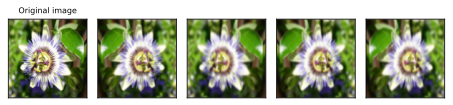

In [9]:
transformed_train = [transforms_1(orig_img) for _ in range(4)]
plot(transformed_train)

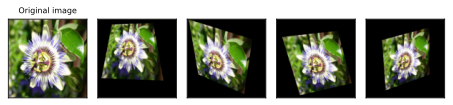

In [10]:
transformed_train = [transforms_2(orig_img) for _ in range(4)]
plot(transformed_train)

### Dane wejściowe

In [11]:
train_transforms = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize(size=(256, 256)),
    transforms.ConvertImageDtype(torch.float),
    transforms.RandomHorizontalFlip()
])

type_transforms = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize(size=(256, 256)),
    transforms.ConvertImageDtype(torch.float),
])

In [12]:
train_dataset = Flowers102(root=DATASET_PATH, 
                           split='test',
                           transform=train_transforms,
                           download=True)
test_dataset = Flowers102(root=DATASET_PATH, 
                           split='train',
                           transform=type_transforms,
                           download=True)
val_dataset = Flowers102(root=DATASET_PATH, 
                           split='val',
                           transform=type_transforms,
                           download=True)

Warto zawsze zbadać dane po zastosowanych transformacjach, żeby nawet na oko zobaczyć czy wartości mają sens. 

In [13]:
for img, label in train_dataset:
    break 
img[0]

tensor([[0.2314, 0.2392, 0.2118,  ..., 0.0784, 0.0196, 0.0039],
        [0.2314, 0.2353, 0.2392,  ..., 0.0784, 0.0275, 0.0039],
        [0.2392, 0.2392, 0.2471,  ..., 0.0549, 0.0275, 0.0039],
        ...,
        [0.0353, 0.0392, 0.0392,  ..., 0.0000, 0.0039, 0.0039],
        [0.0314, 0.0353, 0.0431,  ..., 0.0039, 0.0039, 0.0078],
        [0.0314, 0.0353, 0.0431,  ..., 0.0039, 0.0039, 0.0078]])

In [14]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

6149
1020
1020


In [15]:
help(train_dataset)

Help on Flowers102 in module torchvision.datasets.flowers102 object:

class Flowers102(torchvision.datasets.vision.VisionDataset)
 |  Flowers102(root: Union[str, pathlib.Path], split: str = 'train', transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False) -> None
 |  
 |  `Oxford 102 Flower <https://www.robots.ox.ac.uk/~vgg/data/flowers/102/>`_ Dataset.
 |  
 |  .. warning::
 |  
 |      This class needs `scipy <https://docs.scipy.org/doc/>`_ to load target files from `.mat` format.
 |  
 |  Oxford 102 Flower is an image classification dataset consisting of 102 flower categories. The
 |  flowers were chosen to be flowers commonly occurring in the United Kingdom. Each class consists of
 |  between 40 and 258 images.
 |  
 |  The images have large scale, pose and light variations. In addition, there are categories that
 |  have large variations within the category, and several very similar categories.
 |  
 |  Args:
 |      root (str or `

In [16]:
def concat_imgs(dataset, n=None):
    n = n or len(dataset)
    imgs = [dataset[i][0][None, ...] for i in range(n)]
    data = torch.concatenate(imgs)
    return data

def retrieve_labels(dataset, n=None):
    n = n or len(dataset)
    labels = [dataset[i][1] for i in range(n)]
    data = torch.tensor(labels)
    return data

### Jak ustalić optymalny rozmiar batch'a?

Mamy 3 tryby:
- batch : cały zbiór danych
- mini-batch: część zbioru danych
- stochastic: 1 próbka 

Który tryb jest najlepszy? 
Gdy mamy tryb 'batch', lub ogólnie duży rozmiar batcha (> 200), to czas aktualizacji parametrów dla jednej iteracji się zwiększa, a więc alogrytm zbiega powoli. Trzeba też zauważyć, że nie do końca musimy dokładnie iść w kierunku spadku gradientu, bo jest to kierunek optymalny tylko lokalnie. Lepiej więc wybrać próbkę danych, bo możemy skorzystać wtedy z wektoryzacji. Gdy mamy tryb stochastyczny, to nie możemy z tej wektoryzacji skorzystać, no i pojawia się problem dużego szumu. Ogólnie jednak wybór rozmiaru próbki wpływa na *czas trenowania* i nie za bardzo na *błąd na danych testowych*.

Gdy używacie lightning, to może być ciekawe: [batch-size-finder](https://lightning.ai/docs/pytorch/stable/advanced/training_tricks.html#batch-size-finder)

In [17]:
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=64, shuffle=False)

## Sieć konwolucyjna

### Pojedyncza warstwa konwolucyjna
Jest to nasz pojedyczny 'klocek' budulcowy do całej sieci neuronowej

In [18]:
class ConvLayer(nn.Module):

    def __init__(self, in_channels, out_channels, kernel=(2, 2), stride=(1, 1), padding=0, 
                 pooling=None, batch_norm=True, activ=nn.ReLU):
        super(ConvLayer, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel, stride=stride,
                            padding=padding)
        ]

        if pooling:
           layers.append(nn.MaxPool2d(kernel_size=pooling)) 

        if activ:
            layers.append(activ())

        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        
        
        self.layers = nn.Sequential(*layers)


    def forward(self, x):
        return self.layers(x)

In [19]:
X = torch.rand(1, 3, 4, 4)  # C, W, H

In [20]:
conv = ConvLayer(in_channels=3, out_channels=16)
conv(X).shape

torch.Size([1, 16, 3, 3])

In [21]:
conv = ConvLayer(in_channels=3, out_channels=16, padding=2, stride=2) 
conv(X).shape

torch.Size([1, 16, 4, 4])

In [22]:
conv = ConvLayer(in_channels=3, out_channels=16, padding=2, stride=2, pooling=2) 
conv(X).shape

torch.Size([1, 16, 2, 2])

#### Sieć neuronowa 

In [23]:
class BaseCNN(nn.Module):

    def __init__(self, conv_layers: List[ConvLayer], linear_layers: List[nn.Linear], act_fun = nn.ReLU):
        super(BaseCNN, self).__init__()
        self.conv_layers = nn.Sequential(*conv_layers)
        self.lin_layers = nn.ModuleList(linear_layers)
        self.act_fun = act_fun()


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        for lin_layer in self.lin_layers[:-1]:
            x = self.act_fun(lin_layer(x))
        # Po ostatniej warstwie nie dodajemy już funkcji aktywacji bo chcemy, żeby sieć zwracała logit'y
        x = self.lin_layers[-1](x)
        return x

In [24]:
def compute_dim(d_in, padding, kernel, stride, pooling=1):
    return (int((d_in + 2 * padding - (kernel - 1) - 1) / stride) + 1) // pooling

In [25]:
d_1 = compute_dim(d_in=256, padding=1, kernel=3, stride=1)
print(f"d_1 = ", d_1)
d_2 = compute_dim(d_in=d_1, padding=1, kernel=3, stride=2)
print(f"d_2 = ", d_2)
d_3 = compute_dim(d_in=d_2, padding=1, kernel=3, stride=2)
print(f"d_3 = ", d_3)
d_4 = compute_dim(d_in=d_3, padding=1, kernel=3, stride=1, pooling=2)
print(f"d_4 = ", d_4)
d_5 = compute_dim(d_in=d_4, padding=1, kernel=3, stride=2, pooling=2)
print(f"d_5 = ", d_5)
d_6 = compute_dim(d_in=d_5, padding=1, kernel=3, stride=2, pooling=2)
print(f"d_6 = ", d_6)

d_1 =  256
d_2 =  128
d_3 =  64
d_4 =  32
d_5 =  8
d_6 =  2


### Wszystkie warstwy modelu
Ostateczny model będzie się składał z warstw konwolucyjnych, a na końcu z warstw liniowych. Wszystkie rozmiary muszą się zgadzać, więc dobrze jest to sobie poobliczać np. z użyciem powyższych funkcji

In [26]:
conv_layers = [
    ConvLayer(3, 32, 3, padding=1, stride=1, batch_norm=True),  # C, W, H = ()
    ConvLayer(32, 64, 3, padding=1, stride=2, batch_norm=True),
    ConvLayer(64, 64, 3, padding=1, stride=2, batch_norm=True),
    ConvLayer(64, 128, 3, padding=1, stride=1, pooling=2, batch_norm=True),
    ConvLayer(128, 256, 3, padding=1, stride=2, pooling=2, batch_norm=True),
    ConvLayer(256, 256, 3, padding=1, stride=2, pooling=2, batch_norm=True)
]

input_dim = 256 * 2 * 2 # C x W x H
n_classes = 102

linear_layers = [
    nn.Linear(input_dim, 1024), nn.Linear(1024, 512), nn.Linear(512, n_classes)
]

### LightningModule
Nie jest siecią samą w sobie, ale nakładką na nią. Standardowo nadpisujemy funkcje które są obecne poniżej, ale w ofercie jest ich o wiele więcej. 

#### Jak dobrać parametry uczenia?

*Współczynnik uczenia* - zwykle najważniejszy hiperparametr i jeśli możemy dostosować jeden hiperparamet, to warto właśnie ten. Dla ustandaryzowanych wejść (albo z zakresu (0, 1)) 'dobre' wartości są w przedziale [$10^{-6}$, $1$]. Domyślne $0.01$ typowo działa, ale warto też wypróbować inne wartości. 

Współczynnik uczenia może ulegać zmianom w trakcie uczenia, np:
- $lr_{t}$ ~ $\frac{1}{t}$
- $lr_{t}$ ~ $\frac{1}{max(\tau, t)}$


Algorytm optymalizujący odpowiada za zmiany wartości parametrów w trakcie uczenia:
- **SGD**: $w = w - lr \times g_t$
- **Adagrad**: $w = w - \frac{lr}{\sqrt{G_t}} \times g_t$, $G_t$ to akumulowany gradient
- **Adam**: popularny wybór, mocno uguntowany teoretycznie (rekomendowane wtedy $lr = 10^{-3}$)

In [27]:
class CNN(pl.LightningModule):

    def __init__(self, cnn, lr=1e-3):
        super().__init__()
        self.cnn = cnn 
        self.lr = lr 

    def forward(self, x):
        return self.cnn(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)
        loss = F.cross_entropy(predictions, y)
        self.log('train_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)
        loss = F.cross_entropy(predictions, y)
        self.log('val_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        return {'val_loss': loss}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, _ = batch
        predictions = self(x)
        predicted_labels = torch.argmax(predictions, dim=-1)
        return predicted_labels

    def configure_optimizers(self):
        # W przypadku skomplikowanych modeli można dodać więcej optymizatorów
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


In [28]:
base_cnn = BaseCNN(conv_layers=conv_layers, linear_layers=linear_layers)

cnn = CNN(base_cnn)

Warto zauważyć bottleneck między przejściem z sieci konwolucyjnych do sieci liniowej - jest to miejsce gdzie będzie zwykle najwięcej parametrów

In [29]:
summary(model=cnn, input_size=(3, 256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
       BatchNorm2d-3         [-1, 32, 256, 256]              64
         ConvLayer-4         [-1, 32, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
              ReLU-6         [-1, 64, 128, 128]               0
       BatchNorm2d-7         [-1, 64, 128, 128]             128
         ConvLayer-8         [-1, 64, 128, 128]               0
            Conv2d-9           [-1, 64, 64, 64]          36,928
             ReLU-10           [-1, 64, 64, 64]               0
      BatchNorm2d-11           [-1, 64, 64, 64]             128
        ConvLayer-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]          73,856
        MaxPool2d-14          [-1, 128,

### Przygotowanie do trenowania

#### Jak dobrać liczbę epok?
Tutaj zwykle problemu unikniemy używając techniki *EarlyStopping*, która śledzi wybraną metrykę (na zbiorze walidacyjnym!) i jeśli przez n epok się ona nie poprawia, to zatrzymujemy trenowanie. Jeśli jednak dopiero eksperymentujemy, dobieramy parametry czy architekturę, to lepiej jest po prostu trenować przez daną liczbę epok, bez wcześniejszego przerywania, bo wtedy możemy porównać te modele.

Ważne jest obserwowanie *krzywych uczenia* dla zbioru treningowego i walidacyjnego [generalization gap](https://mlstory.org/generalization.html), [bias-variance](https://mlu-explain.github.io/bias-variance/). 

In [30]:
checkpoint_dir = Path(f'../models')
os.makedirs(checkpoint_dir, exist_ok=True)
model_name = 'cnn-1'
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir / model_name, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)
max_epochs = 25

In [31]:
trainer = pl.Trainer(max_epochs=max_epochs, 
                     default_root_dir=checkpoint_dir / model_name, 
                     fast_dev_run=True, # True dla szybkiego przebiegu sprawdzającego, czy wszystkie warstwy są poprawne itd.
                     callbacks=[checkpoint_callback]
                     )

trainer.fit(cnn, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\julia\anaconda3\envs\plant-traits\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\julia\VSCode\PlantTraits2024\models\cnn-1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | cnn  | BaseCNN | 2.6 M  | train
---------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


#### Ewaluacja

In [40]:
trainer = pl.Trainer(max_epochs=max_epochs, default_root_dir=checkpoint_dir / model_name, fast_dev_run=False)

base_cnn = BaseCNN(conv_layers=conv_layers, linear_layers=linear_layers)
cnn = CNN(base_cnn, lr=1e-2)
model = CNN.load_from_checkpoint(r'C:\Users\julia\VSCode\PlantTraits2024\models\cnn-1\epoch=22-val_loss=2.66-train_loss=1.84.ckpt', cnn=base_cnn)
model.eval()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


CNN(
  (cnn): BaseCNN(
    (conv_layers): Sequential(
      (0): ConvLayer(
        (layers): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ConvLayer(
        (layers): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): ConvLayer(
        (layers): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (3): ConvLayer(
        (layers): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         

In [41]:
y_test = trainer.predict(model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\julia\anaconda3\envs\plant-traits\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [43]:
y_labels = np.concatenate([labels.cpu().numpy() for _, labels in iter(test_loader)])

precision, recall, f1score, support = precision_recall_fscore_support(y_labels, torch.concat(y_test).numpy())
clf_report_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1score, 'support': support},
                                 index=(np.arange(102)))
clf_report_df.sort_values(by='f1_score')

c:\Users\julia\anaconda3\envs\plant-traits\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1_score,support
79,0.000000,0.0,0.000000,10
52,0.000000,0.0,0.000000,10
62,0.000000,0.0,0.000000,10
33,0.000000,0.0,0.000000,10
66,0.000000,0.0,0.000000,10
...,...,...,...,...
7,0.769231,1.0,0.869565,10
1,0.769231,1.0,0.869565,10
58,0.900000,0.9,0.900000,10
36,0.900000,0.9,0.900000,10


<Axes: xlabel='f1_score', ylabel='Count'>

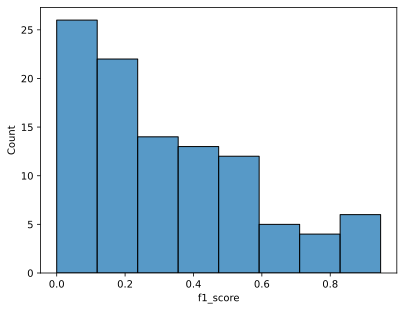

In [44]:
sns.histplot(data=clf_report_df, x='f1_score')

### Ręczne przeszukiwanie, przeszukiwanie siatką

Szukanie dobrej wartości hiperparametru stawia wyzwania:
- osiągnięcie niskiej wartości błędu na zbiorze walidacyjnym
- osiągnięcie generalizacji poza zbiór walidacyjny


*skorch* - wrapper dla PyTorch do biblioteki scikit-learn, więcej można podpatrzeć tutaj: [How to Grid Search Hyperparameters for PyTorch Models](https://machinelearningmastery.com/how-to-grid-search-hyperparameters-for-pytorch-models/)

In [45]:
from skorch import NeuralNet
from skorch import callbacks

net = NeuralNet(
    module=BaseCNN,
    module__conv_layers=conv_layers,
    module__linear_layers=linear_layers,
    criterion=nn.CrossEntropyLoss,
    max_epochs=25,
    batch_size=64,
    callbacks=[
        callbacks.ProgressBar(),
        callbacks.EarlyStopping()
    ],
    device='cuda'
)

In [46]:
param_grid = {
    'optimizer': [optim.SGD, optim.Adam, optim.Adagrad],
    'optimizer__lr': [0.001, 0.01, 0.1]
}

#### Dostosowanie zbioru pod bibliotekę sklearn

ostatecznie wielkość danych się zmniejszy bo wszystko na raz ładujemy, ale nadal takie coś może być przydatną wskazówką co do ustawień, o ile próbka będzie odpowiednio dobrana (biorąc pod uwagę np. niezbalansowanie klas) 

In [47]:
X_val_npy = concat_imgs(val_dataset).numpy()
y_val_npy = retrieve_labels(val_dataset).numpy()

In [48]:
from sklearn.metrics import accuracy_score

def score(estimator, X, y):
    logits = estimator.predict(X)
    prob = F.softmax(torch.tensor(logits), dim=-1).detach().numpy()
    labels = np.argmax(prob, axis=-1)
    return accuracy_score(y, labels)

In [49]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=net, param_grid=param_grid, verbose=4, cv=2, refit=False, return_train_score=True, scoring=score, error_score='raise'
)

In [50]:
grid.fit(X_val_npy, y_val_npy)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.7585        1.3566  2.1965


  0%|          | 0/9 [00:00<?, ?it/s]

      2        3.7190        1.4776  1.5732


  0%|          | 0/9 [00:00<?, ?it/s]

      3        3.6822        1.5519  1.6147


  0%|          | 0/9 [00:00<?, ?it/s]

      4        3.6471        1.5880  1.7049


  0%|          | 0/9 [00:00<?, ?it/s]

      5        3.6137        1.6065  1.5943


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 1/2] END optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.001;, score=(train=0.408, test=0.306) total time=  11.7s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        4.0219        3.5510  1.5825


  0%|          | 0/9 [00:00<?, ?it/s]

      2        3.9571        3.5824  1.6353


  0%|          | 0/9 [00:00<?, ?it/s]

      3        3.8978        3.5925  1.6178


  0%|          | 0/9 [00:00<?, ?it/s]

      4        3.8437        3.5870  1.7705


  0%|          | 0/9 [00:00<?, ?it/s]

      5        3.7933        3.5717  1.7016


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 2/2] END optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.001;, score=(train=0.320, test=0.408) total time=  11.0s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.7372        1.3300  1.6586


  0%|          | 0/9 [00:00<?, ?it/s]

      2        3.4446        1.4670  1.7473


  0%|          | 0/9 [00:00<?, ?it/s]

      3        3.2605        1.5681  1.7034


  0%|          | 0/9 [00:00<?, ?it/s]

      4        3.1301        1.6357  1.6867


  0%|          | 0/9 [00:00<?, ?it/s]

      5        3.0294        1.6824  1.7230


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 1/2] END optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01;, score=(train=0.445, test=0.261) total time=  11.1s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.9390        3.3690  1.6006


  0%|          | 0/9 [00:00<?, ?it/s]

      2        3.5367        3.3252  1.6764


  0%|          | 0/9 [00:00<?, ?it/s]

      3        3.3114        3.2929  1.6822


  0%|          | 0/9 [00:00<?, ?it/s]

      4        3.1581        3.2910  1.7001


  0%|          | 0/9 [00:00<?, ?it/s]

      5        3.0419        3.3066  1.7242


  0%|          | 0/9 [00:00<?, ?it/s]

      6        2.9457        3.3215  1.7265


  0%|          | 0/9 [00:00<?, ?it/s]

      7        2.8628        3.3420  1.7405


  0%|          | 0/9 [00:00<?, ?it/s]

      8        2.7939        3.3734  1.7406


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 2/2] END optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.01;, score=(train=0.388, test=0.324) total time=  16.2s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.8563        2.3761  1.7190


  0%|          | 0/9 [00:00<?, ?it/s]

      2        3.2603        2.1370  1.7388


  0%|          | 0/9 [00:00<?, ?it/s]

      3        2.8832        2.2915  1.7656


  0%|          | 0/9 [00:00<?, ?it/s]

      4        2.6715        2.6231  1.7631


  0%|          | 0/9 [00:00<?, ?it/s]

      5        2.5450        2.8296  1.7316


  0%|          | 0/9 [00:00<?, ?it/s]

      6        2.4210        3.0620  1.7325


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 1/2] END optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.1;, score=(train=0.382, test=0.116) total time=  13.1s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.9372        3.6306  1.7656


  0%|          | 0/9 [00:00<?, ?it/s]

      2        2.9488        4.0138  1.7276


  0%|          | 0/9 [00:00<?, ?it/s]

      3        2.6362        4.3271  1.7424


  0%|          | 0/9 [00:00<?, ?it/s]

      4        2.4255        4.5389  1.7525


  0%|          | 0/9 [00:00<?, ?it/s]

      5        2.2501        4.7751  1.7585


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 2/2] END optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__lr=0.1;, score=(train=0.406, test=0.110) total time=  11.3s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.8054        1.4514  1.6223


  0%|          | 0/9 [00:00<?, ?it/s]

      2        3.0981        1.5998  1.7474


  0%|          | 0/9 [00:00<?, ?it/s]

      3        2.8009        1.7045  1.7676


  0%|          | 0/9 [00:00<?, ?it/s]

      4        2.6029        1.7580  1.7312


  0%|          | 0/9 [00:00<?, ?it/s]

      5        2.4429        1.7964  1.7336


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 1/2] END optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.001;, score=(train=0.463, test=0.237) total time=  11.2s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.9200        3.3403  1.7588


  0%|          | 0/9 [00:00<?, ?it/s]

      2        3.2050        3.2399  1.7118


  0%|          | 0/9 [00:00<?, ?it/s]

      3        2.8544        3.2524  1.7304


  0%|          | 0/9 [00:00<?, ?it/s]

      4        2.6132        3.3187  1.7324


  0%|          | 0/9 [00:00<?, ?it/s]

      5        2.4172        3.4015  1.7279


  0%|          | 0/9 [00:00<?, ?it/s]

      6        2.2549        3.5053  1.7327


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 2/2] END optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.001;, score=(train=0.441, test=0.318) total time=  13.1s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        4.5646        4.5616  1.7505


  0%|          | 0/9 [00:00<?, ?it/s]

      2        2.9915        4.6950  1.6802


  0%|          | 0/9 [00:00<?, ?it/s]

      3        2.3730        4.6187  1.7499


  0%|          | 0/9 [00:00<?, ?it/s]

      4        1.8054        5.1474  1.8020


  0%|          | 0/9 [00:00<?, ?it/s]

      5        1.3741        5.8939  1.7720


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 1/2] END optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01;, score=(train=0.514, test=0.012) total time=  11.5s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        4.1497        4.1116  1.7562


  0%|          | 0/9 [00:00<?, ?it/s]

      2        2.3653        4.5510  1.7342


  0%|          | 0/9 [00:00<?, ?it/s]

      3        1.8244        5.1226  1.8012


  0%|          | 0/9 [00:00<?, ?it/s]

      4        1.3926        5.8125  1.7673


  0%|          | 0/9 [00:00<?, ?it/s]

      5        1.1087        6.8285  1.7712


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 2/2] END optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.01;, score=(train=0.529, test=0.020) total time=  11.4s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        8.2147      261.1404  1.7300


  0%|          | 0/9 [00:00<?, ?it/s]

      2        4.3805      799.7221  1.6534


  0%|          | 0/9 [00:00<?, ?it/s]

      3        4.1273      366.4548  1.6569


  0%|          | 0/9 [00:00<?, ?it/s]

      4        3.9824      250.1446  1.6738


  0%|          | 0/9 [00:00<?, ?it/s]

      5        3.9013       52.1830  1.7220


  0%|          | 0/9 [00:00<?, ?it/s]

      6        3.8555        9.9704  1.6782


  0%|          | 0/9 [00:00<?, ?it/s]

      7        3.8294        7.6534  1.6700


  0%|          | 0/9 [00:00<?, ?it/s]

      8        3.8144        7.8357  1.6561


  0%|          | 0/9 [00:00<?, ?it/s]

      9        3.8054        7.9890  1.6602


  0%|          | 0/9 [00:00<?, ?it/s]

     10        3.7997        8.1216  1.6947


  0%|          | 0/9 [00:00<?, ?it/s]

     11        3.7957        8.2393  1.5554


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 1/2] END optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.1;, score=(train=0.020, test=0.000) total time=  20.8s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       10.8964        4.9873  1.7706


  0%|          | 0/9 [00:00<?, ?it/s]

      2        4.4061        5.4274  1.6897


  0%|          | 0/9 [00:00<?, ?it/s]

      3        4.1345       18.2033  1.7183


  0%|          | 0/9 [00:00<?, ?it/s]

      4        3.9755       20.9819  1.7366


  0%|          | 0/9 [00:00<?, ?it/s]

      5        4.1558        6.6974  1.9712


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 2/2] END optimizer=<class 'torch.optim.adam.Adam'>, optimizer__lr=0.1;, score=(train=0.020, test=0.000) total time=  11.6s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.7578        1.3471  1.8346


  0%|          | 0/9 [00:00<?, ?it/s]

      2        3.4638        1.4827  1.8026


  0%|          | 0/9 [00:00<?, ?it/s]

      3        3.3280        1.5659  1.8415


  0%|          | 0/9 [00:00<?, ?it/s]

      4        3.2318        1.6101  1.8462


  0%|          | 0/9 [00:00<?, ?it/s]

      5        3.1574        1.6217  1.8270


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 1/2] END optimizer=<class 'torch.optim.adagrad.Adagrad'>, optimizer__lr=0.001;, score=(train=0.431, test=0.310) total time=  12.1s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.9619        3.4262  1.8554


  0%|          | 0/9 [00:00<?, ?it/s]

      2        3.5955        3.4187  1.8887


  0%|          | 0/9 [00:00<?, ?it/s]

      3        3.4337        3.4026  1.8323


  0%|          | 0/9 [00:00<?, ?it/s]

      4        3.3189        3.3895  3.8941


  0%|          | 0/9 [00:00<?, ?it/s]

      5        3.2298        3.3782  4.2386


  0%|          | 0/9 [00:00<?, ?it/s]

      6        3.1580        3.3690  4.4607


  0%|          | 0/9 [00:00<?, ?it/s]

      7        3.0974        3.3645  4.3120


  0%|          | 0/9 [00:00<?, ?it/s]

      8        3.0442        3.3655  4.1091


  0%|          | 0/9 [00:00<?, ?it/s]

      9        2.9973        3.3665  4.1346


  0%|          | 0/9 [00:00<?, ?it/s]

     10        2.9553        3.3673  4.1765


  0%|          | 0/9 [00:00<?, ?it/s]

     11        2.9180        3.3663  4.0300


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 2/2] END optimizer=<class 'torch.optim.adagrad.Adagrad'>, optimizer__lr=0.001;, score=(train=0.359, test=0.394) total time=  45.2s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.9255        1.5625  4.1268


  0%|          | 0/9 [00:00<?, ?it/s]

      2        2.7894        1.7637  4.0572


  0%|          | 0/9 [00:00<?, ?it/s]

      3        2.2803        1.9189  4.1273


  0%|          | 0/9 [00:00<?, ?it/s]

      4        2.0429        1.9674  4.0441


  0%|          | 0/9 [00:00<?, ?it/s]

      5        1.8547        2.0336  4.2841


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 1/2] END optimizer=<class 'torch.optim.adagrad.Adagrad'>, optimizer__lr=0.01;, score=(train=0.545, test=0.186) total time=  26.7s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.9966        3.4211  4.1134


  0%|          | 0/9 [00:00<?, ?it/s]

      2        2.5916        3.7048  4.1288


  0%|          | 0/9 [00:00<?, ?it/s]

      3        2.1544        4.0455  4.2444


  0%|          | 0/9 [00:00<?, ?it/s]

      4        1.9210        4.0708  4.4674


  0%|          | 0/9 [00:00<?, ?it/s]

      5        1.7410        4.2762  4.2804


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 2/2] END optimizer=<class 'torch.optim.adagrad.Adagrad'>, optimizer__lr=0.01;, score=(train=0.475, test=0.225) total time=  27.4s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       15.7062        5.3508  4.3138


  0%|          | 0/9 [00:00<?, ?it/s]

      2        4.5771        5.4741  4.1498


  0%|          | 0/9 [00:00<?, ?it/s]

      3        4.4665        5.5683  4.1694


  0%|          | 0/9 [00:00<?, ?it/s]

      4        4.3922        5.6478  4.0770


  0%|          | 0/9 [00:00<?, ?it/s]

      5        4.3361        5.7177  4.0477


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 1/2] END optimizer=<class 'torch.optim.adagrad.Adagrad'>, optimizer__lr=0.1;, score=(train=0.020, test=0.000) total time=  27.2s


  0%|          | 0/9 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       20.2851        4.8787  4.0698


  0%|          | 0/9 [00:00<?, ?it/s]

      2        7.1201        5.0072  4.2034


  0%|          | 0/9 [00:00<?, ?it/s]

      3        4.5174        5.1106  4.0150


  0%|          | 0/9 [00:00<?, ?it/s]

      4        4.4363        5.1944  4.1046


  0%|          | 0/9 [00:00<?, ?it/s]

      5        4.3752        5.2667  4.0207


  0%|          | 0/9 [00:00<?, ?it/s]

Stopping since valid_loss has not improved in the last 5 epochs.
[CV 2/2] END optimizer=<class 'torch.optim.adagrad.Adagrad'>, optimizer__lr=0.1;, score=(train=0.020, test=0.000) total time=  26.5s


GridSearchCV(cv=2, error_score='raise',
             estimator=<class 'skorch.net.NeuralNet'>[uninitialized](
  module=<class '__main__.BaseCNN'>,
  module__conv_layers=[ConvLayer(
    (layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  ), ConvLayer(
    (layers): S...
  module__linear_layers=[Linear(in_features=1024, out_features=1024, bias=True), Linear(in_features=1024, out_features=512, bias=True), Linear(in_features=512, out_features=102, bias=True)],
),
             param_grid={'optimizer': [<class 'torch.optim.sgd.SGD'>,
                                       <class 'torch.optim.adam.Adam'>,
                                       <class 'torch.optim.adagrad.Adagrad'>],
                         'optimizer__lr': [0.001, 0.01, 0.1]},
             refit=False, return_train_score=True,
             scoring=<function score at 0x000002AB6CD0C160>, verbose=4)

In [53]:
grid.best_score_

0.3568627450980392

In [54]:
grid.best_params_

{'optimizer': torch.optim.sgd.SGD, 'optimizer__lr': 0.001}